### 1D Burger Equation NFTM Simulator using a RNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a RNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ RNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using RNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the RNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The RNN uses this input to compute updates by applying a RNN kernel and then writes the updated values back to the same region.

#### Import necessary packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader

#### Training Data

In [3]:
class BurgersDataset(Dataset):
    def __init__(self, datasets, viscosities):
        # datasets: list of tensors (1, T, N), one per viscosity
        # viscosities: list of scalar viscosities
        
        self.data_by_nu = []  # list of trajectories for each nu
        self.nu_values = []   # matched viscosities (one per trajectory)
        
        for data, nu in zip(datasets, viscosities):
            data = data.squeeze(0)  # (T, N)
            T, N = data.shape
            # Store as individual trajectories here
            self.data_by_nu.append(data)
            self.nu_values.append(nu)
        
    def __len__(self):
        return len(self.data_by_nu)
    
    def __getitem__(self, idx):
        # Returns: tuple (initial_field (N,), full_trajectory (T, N), viscosity (1,))
        traj = self.data_by_nu[idx]        # (T, N)
        nu_val = torch.tensor([self.nu_values[idx]], dtype=torch.float32)
        return traj, nu_val
    

current_dir = Path(os.getcwd()) # get current directory

# Files with datasets for 1D burger eq for different values of viscosity:
files_burger = {
    0.001: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.001.npz",
    0.01: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.01.npz",
    0.1: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.1.npz",
    0.5: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.5.npz"
}

datasets = [] # list to store tensors corresponding to each dataset: each tensor has shape (1, T, N)
viscosities = [] # list to store the different values of viscosity.

# Load and process all datasets:
for viscosity, path in files_burger.items():
    uu_tensor = np.load(str(path.resolve()))['u'] # shape (T, N)
    data_tensor = torch.tensor(uu_tensor, dtype=torch.float32).unsqueeze(0) # (1, T, N)
    datasets.append(data_tensor)
    viscosities.append(viscosity)


# The training dataset for our NFTM will consist of 4 samples (trajectories), one per viscosity value:
dataset = BurgersDataset(datasets, viscosities)
# print("Patches shape:", patch_dataset.patches.shape)   # (total_samples, patch_size)
# print("Viscosities shape:", patch_dataset.nu_vals.shape)  # (total_samples, 1)
# print("Targets shape:", patch_dataset.targets.shape)  # (total_samples, 1)
print(f"Number of trajectories in dataset: {len(dataset)}")

T = datasets[0].shape[1]  # datasets[0] has shape (1, T, N)
N = datasets[0].shape[2]  # datasets[0] has shape (1, T, N)

print(f"N={N}")
print(f"T={T}")

full_trajectory, viscosity = dataset[0]
print(f"Full trajectory shape: {full_trajectory.shape}")     # Expected: (T, N)
print(f"Viscosity: {viscosity.item()}")



Number of trajectories in dataset: 4
N=1024
T=201
Full trajectory shape: torch.Size([201, 1024])
Viscosity: 0.0010000000474974513


#### Continuous field

* In this case, we continuous field is a chunk of data of size $20 \times 1024$. This represents the solution $u(x,t)$ at $20$ time snapshots at all positions $x$.

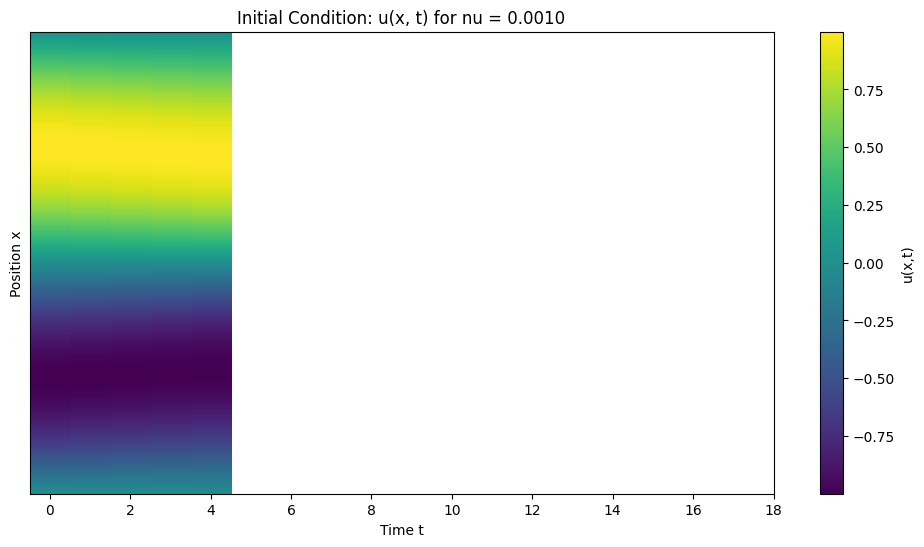

In [4]:
chunk_size = 5  # number of time snapshots per chunk

full_trajectory, viscosity = dataset[0] # initial field for t = 0, full trajectory for nu = 0.001

# Select the window from the full trajectory
initial_field = full_trajectory[0 : 0 + chunk_size, :]  # shape (chunk_size, N)

# VISUALIZATION OF THE FIELD:
# Convert to numpy and transpose to (space, time) for plotting
field_np = initial_field.numpy().T  # shape (N, chunk_size)
xticks_positions = np.arange(0, 20, 2)
xticks_labels = xticks_positions.tolist()

plt.figure(figsize=(12, 6))
plt.imshow(field_np, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='u(x,t)')
plt.ylabel('Position x')
plt.xlabel('Time t')
plt.xticks(xticks_positions, xticks_labels)
plt.yticks([])
plt.title(f'Initial Condition: u(x, t) for nu = {viscosity.item():.4f}')
plt.show()

#### RNN controller

* `Input`: patches of the field at the current time step along with viscosity values, just as for the CNN controller.

* Now, instead of convolutions, we use an RNN cell (`LSTM` or `GRU`) to process the input features sequentially or in batch.

* `Output`: the predicted field value at the center of each patch.

* Since our data is spatial, each patch can be a `timestep sequence` for the RNN.

* Fully connected layers after the RNN to map hidden states to predictions.

* We treat each patch vector as a single time step with 3 features (patch_size=3). The **features** represent the **local neighbourhood**.

* **patch_size = 3 $\to$ 3 features at one timestep.**

* **Sequence length = 1** since we process one patch at a time.

* **Input size = patch_size + 1** (features + viscosity).


In [5]:
class RNNController(nn.Module):
    def __init__(self, patch_size, hidden_size=64, rnn_type='LSTM'):
        super().__init__()
        self.patch_size = patch_size
        input_size = patch_size + 1  # patch (features) + viscosity scalar
        
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        else:
            print("RNN type must be 'LSTM' or 'GRU'")
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # output prediction for patch center
        )

    def forward(self, patch, nu):
        # patch: (batch_size, chunk_size, patch_size)
        # nu: (batch_size, 1)
        # Expand nu to (batch_size, seq_len, 1) for concatenation
        nu_expanded = nu.unsqueeze(1).expand(-1, patch.size(1), -1)  # (batch_size, chunk_size, 1)
        rnn_input = torch.cat([patch, nu_expanded], dim=-1)
        # shape: (batch_size, chunk_size, patch_size + 1)
        output, _ = self.rnn(rnn_input)  # output: (batch_size, chunk_size, hidden_size)
        # Use the last output (corresponding to center patch point) for prediction
        last_output = output[:, -1, :] 
        # shape: (batch_size, hidden_size)
        pred = self.fc(last_output)
        # shape: (batch_size, 1)
        return pred.squeeze(1)
    

# Create RNN controller for our NFTM:
rnn_controller = RNNController(patch_size = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_controller.to(device)
print(rnn_controller)

RNNController(
  (rnn): LSTM(4, 64, batch_first=True)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)


#### Extraction of patches

In [6]:
# We pass as argument the batch of fields.
def extract_patches(fields_batch, patch_radius=1):
    # fields_batch shape: (batch_size, chunk_size, N)
    # batch_size: number of samples in the batch
    # chunk_size: number of time snapshots per chunk
    # N: number of spatial points
    # Returns: patches of shape (batch_size, chunk_size, N, patch_size)
    batch_size, chunk_size, N = fields_batch.shape
    patch_size = 2 * patch_radius + 1
    # add channel dimension for padding, shape: (batch_size, chunk_size, 1, N)
    x = fields_batch.unsqueeze(2)  # (batch_size, 1, N)
    pad = nn.ReplicationPad1d(patch_radius)
    # we pad each sample in batch independently
    padded = pad(x.reshape(batch_size * chunk_size, 1, N))  # (batch_size*chunk_size, 1, N + 2*patch_radius)
    patches = padded.unfold(dimension=2, size=patch_size, step=1)  # (batch_size*chunk_size, 1, N, patch_size)
    # reshape back to (batch_size, chunk_size, N, patch_size)
    patches = patches.view(batch_size, chunk_size, N, patch_size)  # (batch_size, chunk_size, N, patch_size)
    return patches

#### Loss Function

In [7]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

In [8]:
optimizer = torch.optim.Adam(rnn_controller.parameters(), lr=1e-3) # OPTIMIZER

#### Training Loop

In [62]:
def plot_learning_progress(true_traj, pred_traj, epoch, sample_idx=0):
    # error = (true_traj - pred_traj) ** 2
    true_np = true_traj.cpu().numpy().T  # (space, time)
    pred_np = pred_traj.cpu().numpy().T
    error_np = (true_np - pred_np) ** 2

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(true_np, aspect='auto', cmap='viridis')
    plt.colorbar(label='u(x,t=0)')
    plt.xlabel('Time t')
    plt.ylabel('Position x')
    plt.title(f'True Trajectory (Sample {sample_idx})')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_np, aspect='auto', cmap='viridis')
    plt.colorbar(label='u(x,t=0)')
    plt.xlabel('Time t')
    plt.ylabel('Position x')
    plt.title(f'Predicted Trajectory (Epoch {epoch})')

    plt.subplot(1, 3, 3)
    plt.imshow(error_np, aspect='auto', cmap='inferno')
    plt.colorbar(label='error')
    plt.xlabel('Time t')
    plt.ylabel('Position x')
    plt.title('Absolute Error')

    plt.tight_layout()
    plt.show()


def psnr(true, pred, max_val=1.0):
    mse = torch.mean((true - pred) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * torch.log10(max_val**2 / mse)


def gaussian(window_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/(2*sigma**2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel=1):
    _1d_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2d_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(true, pred, window_size=11, size_average=True, val_range=1.0):
    # Assume inputs are 2D tensors (Height=space, Width=time) or batch versions
    # Convert to 4D tensor [N,C,H,W] for conv2d
    if true.dim() == 2:
        true = true.unsqueeze(0).unsqueeze(0)
        pred = pred.unsqueeze(0).unsqueeze(0)

    channel = true.size(1)
    window = create_window(window_size, channel).to(true.device)

    mu1 = torch.nn.functional.conv2d(true, window, padding=window_size//2, groups=channel)
    mu2 = torch.nn.functional.conv2d(pred, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = torch.nn.functional.conv2d(true * true, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = torch.nn.functional.conv2d(pred * pred, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = torch.nn.functional.conv2d(true * pred, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = (0.01 * val_range) ** 2
    C2 = (0.03 * val_range) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean().item() if size_average else ssim_map


train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

rnn_controller.train()
num_epochs = 30
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for true_trajectories_batch, viscosities_batch in train_loader:
        true_trajectories_batch = true_trajectories_batch.to(device) # (batch_size, T, N)
        viscosities_batch = viscosities_batch.to(device)             # (batch_size, 1)

        batch_size, T, N = true_trajectories_batch.shape

        # Predict next step for every time step independently, no autoregressive rollout:
        pred_trajectory = []
        
        for t in range(T - chunk_size):
            current_field = true_trajectories_batch[:, t: t + chunk_size, :]  # ground truth for 20 time snapshots (batch, chunk_size, N)
            next_true = true_trajectories_batch[:, t + chunk_size, :]  # ground truth at t+1 for loss: (batch, N)
            
            patches = extract_patches(current_field, patch_radius=1)  # (batch, chunk_size, N, patch_size)
            patches_reshape = patches.permute(0, 2, 1, 3).reshape(batch_size * N, chunk_size, -1) # (batch*N, chunk_size, patch_size)
            # expand viscosity for each patch
            viscosity_expanded = viscosities_batch.unsqueeze(1).expand(-1, N, -1).reshape(batch_size * N, 1)  # (batch*N, 1)
            # predict each field
            next_pred = rnn_controller(patches_reshape, viscosity_expanded).reshape(batch_size, N) 

            pred_trajectory.append(next_pred)

        # Stack along time: (batch, T-1, N)
        pred_trajectory = torch.stack(pred_trajectory, dim=1)

        # Target - true trajectory excluding initial time step: (batch, T-1, N)
        target_trajectory = true_trajectories_batch[:, 1:, :]

        loss = mse_loss(pred_trajectory, target_trajectory)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

    if (epoch + 1) % 10 == 0:
        rnn_controller.eval()
        with torch.no_grad():
            sample_idx = 0  # fixed index to visualize progress
            initial_field, true_trajectory, viscosity_val = dataset[sample_idx]
            initial_field = initial_field.to(device)
            true_trajectory = true_trajectory.to(device)
            T, N = true_trajectory.shape

            pred_trajectory = []
            for t in range(T - 1):
                current_field = true_trajectory[t]
                patches = extract_patches(current_field.unsqueeze(0), patch_radius=1)
                patches_reshape = patches.reshape(-1, patches.shape[-1])
                nu_vals = torch.full((patches_reshape.shape[0], 1), float(viscosity_val), device=device)
                next_pred = rnn_controller(patches_reshape, nu_vals) # shape (batch_size,)
                pred_trajectory.append(next_pred)
            pred_trajectory = torch.stack(pred_trajectory, dim=0)
            pred_trajectory = torch.cat([initial_field.unsqueeze(0), pred_trajectory], dim=0)

        print("="*50)
        print("Visualization of learning progress at epoch:", epoch + 1)
        plot_learning_progress(true_trajectory, pred_trajectory, epoch + 1)
        print("PSNR and SSIM metrics at epoch:", epoch + 1)
        psnr_val = psnr(true_trajectory, pred_trajectory, max_val=1.0)
        ssim_val = ssim(true_trajectory, pred_trajectory, val_range=1.0)
        print(f"PSNR: {psnr_val:.4f}, SSIM: {ssim_val:.4f}")
        print("="*50 + "\n")
        rnn_controller.train()  # back to training mode


: 

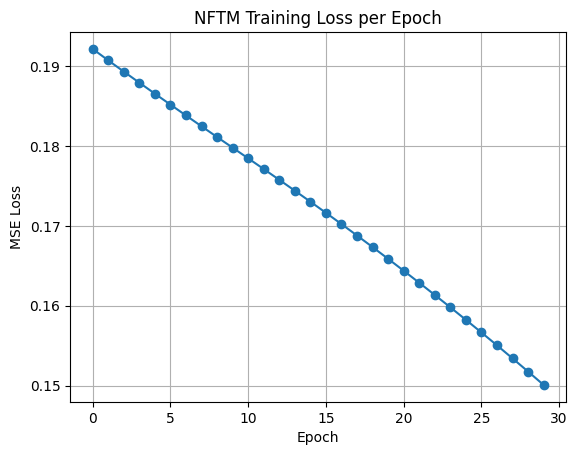

In [32]:
# Loss Evolution Plot
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()